In [1]:
import os
wd = os.getcwd()
wd = os.path.dirname(os.path.dirname(wd))
import sys
sys.path.append(wd+"\\src\\")

In [2]:
from tube import Tube, InterpXY, BorderSimple
from gaslayer import GasEOS, GasFluxCalculator, GridStrecher, GasLayer
from math import *
import numpy as np

In [18]:
from tqdm import tqdm_notebook
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

import json
from functional import seq
import ipdb

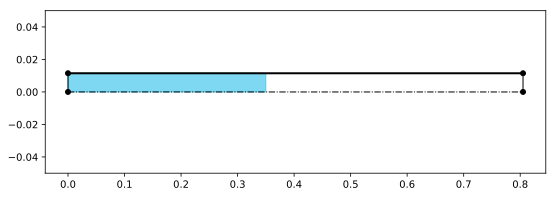

GasLayer(n_cells=300); 
        {'p_max':5000000.0, 'tau_min': 3.360324327272916e-06, 
        'u_max': 0.0, 'cs_max': 347.18870949384285, 'dx_min': 0.0011666666666666492, 
        'x_1': 0.0, 'x_2': 0.35,
        'V_1':  0.0, 'V_2':  0.0  }

In [26]:
d = 0.023
m = 0.035
l_max = 35*d
p0 = 5e6
x_0 = 0.35

gas_layer_dict_sample = {
    'type': 'gas',
    'name': 'N_2',
    'gamma': 1.4,
    'kappa': 0, #0.0010838,
    'R': 287,
    'T_0': 300, # K
    'W_0': 0.0003,  # м^3 объем газа
    'p_0': p0, # начальное давление газа
    'u_0': 0,     #начальная скорость
    'x_2': x_0
}

tube_dict = {
    'tube_points': [[0, d], [l_max, d]]
}

calc_settings_sample = {
    'cell_dx': 0.0025,
    'n_cells': 300,
    'n_cells_min': 13,
    'n_cells_max': 300,
    'GasFluxCalculator_kwargs': {'flux_type':1 },
    'GridStrecher_kwargs': {}
}   
tube=Tube.get_standart(tube_dict)
gl = GasLayer.get_standart(tube, 0, gas_layer_dict_sample, calc_settings_sample)   

fig, ax = plt.subplots()
tube.plot(fig, ax)
gl.plot(fig, ax)
ax.set_ylim(-0.05,0.05)
plt.show()
lrs = [gl]
gl

In [27]:

for i in tqdm_notebook(range(10000)):
    if gl.xs_borders[-1] > l_max:
        break
    tau = gl.get_tau_min()*0.5
    v = gl.Vs_borders[-1] + gl.ps[-1]*pi*d**2/4/m*tau
    gl = gl.step_simple(tau, 0, v)
    lrs.append(gl)

In [28]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(lrs)-1,step=10, value=0))
def plotMe(ind):
    param_name = 'us'
    lr = lrs[ind]
    fig, ax = plt.subplots()
    xs = np.array(lr.xs_cells)
    ys = np.array(getattr(lr, param_name))
    color = lr.color_4_plot
    lw = 2
    ax.plot(xs, ys, color=color, lw=lw)
    plt.grid(True)
    plt.ylabel(param_name)
#     plt.ylim(-1,1)
    plt.title(f't={lr.time*1000} ms; i={ind}')
    plt.show()

interactive(children=(IntSlider(value=0, description='ind', max=1932, step=10), Output()), _dom_classes=('widg…

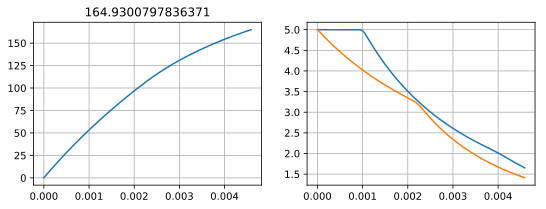

In [29]:
mpl.rcParams['figure.figsize'] = (9,3) 
vt = seq(lrs).map(lambda lr: lr.Vs_borders[-1]).to_list()
t = seq(lrs).map(lambda lr: lr.time).to_list()
p_1 = seq(lrs).map(lambda lr: lr.ps[0]/1e6).to_list() 
p_2 = seq(lrs).map(lambda lr: lr.ps[-1]/1e6).to_list() 
plt.subplot(121)
plt.plot(t, vt)
plt.title(vt[-1])
plt.grid()
plt.subplot(122)
plt.plot(t, p_1)
plt.plot(t, p_2)
plt.grid()
plt.show()

In [30]:
def forw(x_0, p_0, n_cells=300):
    d = 0.023
    m = 0.035
    l_max = 35*d
    p0 = p_0

    gas_layer_dict_sample = {
        'type': 'gas',
        'name': 'N_2',
        'gamma': 1.4,
        'kappa': 0, #0.0010838,
        'R': 287,
        'T_0': 300, # K
        'W_0': 0.0003,  # м^3 объем газа
        'p_0': p0, # начальное давление газа
        'u_0': 0,     #начальная скорость
        'x_2': x_0
    }

    tube_dict = {
        'tube_points': [[0, d], [l_max, d]]
    }

    calc_settings_sample = {
        'cell_dx': 0.0025,
        'n_cells': n_cells,
        'n_cells_min': 13,
        'n_cells_max': 300,
        'GasFluxCalculator_kwargs': {'flux_type':1 },
        'GridStrecher_kwargs': {}
    }   
    tube=Tube.get_standart(tube_dict)
    gl = GasLayer.get_standart(tube, 0, gas_layer_dict_sample, calc_settings_sample)   
    for i in range(30000):
        if gl.xs_borders[-1] > l_max:
            break
        tau = gl.get_tau_min()*0.5
        v = gl.Vs_borders[-1] + gl.ps[-1]*pi*d**2/4/m*tau
        gl = gl.step_simple(tau, 0, v)
    else:
        print(f'Ошибочка в {x_0} {p_0}')
    return v

In [31]:
forw(0.3, 5e6)

164.62482950842383

In [32]:
%timeit forw(0.3, 5e6)

998 ms ± 7.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
